Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE"

Do not edit or insert code into the test cells as all you insert will be overwritten by the automated testing code.

---

**Question 7**: The code in the cell below has errors. There are errors in style, warnings and convention errors. There are also errors preventing the code to run as intended. 

Your **task** is to find all mistakes, remove them, make the code function properly such that it presents a correct figure at the end and achieves a 10 out of 10 marks from the style checker. 

A brief text at the top of the code in comments explains what the code is meant to be doing. It is strongly recommended to start the exercise by copying the entire code to a separate python file and examine it in Spyder. The code checking should then improve your style mark and potentially give hints on errors which the style checker (and Spyder) can not detect.

**Note A**: Leave the function names unchanged. Some will be assumed in tests. Constant values as given are all correct.

**Note B**: Make sure you use the `pylintrc` file from Moodle. Every integer increase in the style mark (0 to 8, 8 to 9, 9 to 10) gains you one point on the style mark, i.e. up to 3 in total.

**Note C**: This exercise involves random numbers hence every figure will look different. Getting a figure at all is already a success. Marking of figures is manual hence checks will be made to see whether a correct figure emerges even if that means running your code several times due to the built in randomness.

**Note D**: The number of pulses produced follows the Poisson distribution and a single pulse is a valid outcome for the sequence. However, checking that your code works correctly, re-run until you see an example with Npulses>1 fully analysed. Only then can you be certain that all mistakes have been removed.

**Note E**: Copy your final solution back into the cell below so that the tests can run.

+n pulses:  5
npe:  1
next onset:  122.07481811995454
npe:  2
next onset:  568.1398885104874
npe:  1
next onset:  893.3971747938014
npe:  1
next onset:  1082.6147326548185
npe:  0
in filtered:  [  51.5  122.5  569.5  894.5 1083.5]
[  10.01765326   50.00292884    2.00354256  149.95690231    9.98381347
  122.09691186    1.98267042  149.73411567   19.97031921  568.15474223
    2.00425513  150.37225072   10.06701617  893.35443994    2.07796073
  147.87768865    9.99529368 1082.60575113    2.02150949  151.15096808]


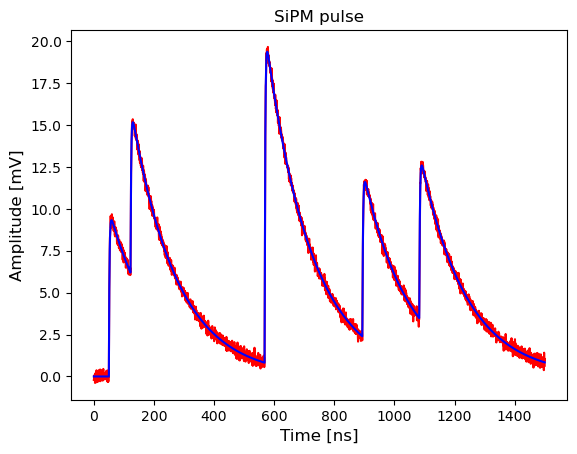

In [1]:
'''
SiPM single event modelling
(a) Make a pulse, always 50 ns after the start of the event.
(b) Randomly decide with the dark count rate how many
    additional pulses should be created.
(c) for more than zero, add additional pulses with random amplitude
    in discrete units of scale and random position in time
    according to exponential distribution and dark count rate.
(d) Analyse event: first filter with matched filter and find peaks.
(e) Use results on peak positions and number to fit all peaks,
    especially if there are more than one.
(f) Draw data and fit.
'''
# YOUR CODE HERE
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit


def matchedFilter(data, template):
    '''
    Parameters
    ----------
    data : given data
    template : what the data is being correlated to
    Returns
    -------
    cross correlation of two 1D sequences
    '''
    return np.correlate(data, template, mode = 'full')



def pulseSequence(t, *pos):
    '''
    Parameters
    ----------
    t : array dimensions
    *pos : super position
    Returns
    -------
    total : a t-shape array of positions
    '''
    total = np.zeros_like(t)
    for idx in range(0, len(pos),4): # superposition of pulses
        total += pulse(t, pos[idx], pos[idx+1], pos[idx+2], pos[idx+3])
    return total



def pulse(time, amplitude, start, rt, dt):
    '''
    Parameters
    ----------
    time : time of pulse
    amplitude : amplitude of pulse
    start : initial time
    rt : rise time
    dt : decay time
    Returns
    -------
    the pulse is negative amplitude times single pulse

    '''
    singlepulse = np.exp(-(time - start) / rt) - np.exp(-(time - start) / dt)
    singlepulse[np.where(time < start)] = 0.0 # not defined before onset time, set 0
    return - amplitude * singlepulse # added minus



def makeTemplate(rt, dt):
    '''
    Parameters
    ----------
    rt : rise time
    dt : decay time
    Returns
    -------
    timevals : time values, 0.05 mus and 0.5 unit step size
    template : the ideal data
    '''
    timevals = np.linspace(0, 50, 101) # 0.05 mus, 0.5 unit step size
    scalefac = 1.0   # some scale factor giving reasonable values
    onsettemp = 0.0    # pulse start [ns]
    dummy = pulse(timevals, scalefac, onsettemp, rt, dt)
    template = dummy / np.trapz(dummy, x = timevals) # normalized
    return timevals, template


def dataProduction(time, cfg):
    '''
    Parameters
    ----------
    time : time
    cfg : configuration of all the parameters
    Returns
    -------
    frame : array of pulses
    '''
    amp = cfg[0]   # some scale factor giving reasonable values
    start = cfg[1]    # pulse start [ns]
    rtime = cfg[2]   # realistic rise time
    dtime = cfg[3] # realistic decay time
    noiselevel = cfg[4] # noise level scale
    dcr = cfg[5] # [1/ns] => 2 MHz

    framestop = time[-1] # final time bin

    # There is always the default pulse, see below.
    # These Npulses add to the default!
    Npulses = np.random.poisson(framestop * dcr)
    while Npulses<1:  # want at least 2 pulses to test analysis
        Npulses = np.random.poisson(framestop * dcr)
    print ('+n pulses: ', Npulses)

    pp = pulse(time, amp, start, rtime, dtime)
    noisy = np.random.normal(pp, scale = noiselevel)
    frame = noisy # first triggered pulse at onset
    npe = 1 # certainty to have one additional pulse, same amplitude
    for _ in range(Npulses): # additional pulses
        print('npe: ', npe)
        pretrigger = start
        triggertime = random.expovariate(dcr) # rate parameter
        start = pretrigger + triggertime
        if start > framestop-300:
            break
        if npe > 0:
            print('next onset: ', start)
            pp = pulse(time, npe * amp, start, rtime, dtime) # added start param
            frame += pp
        npe = np.random.poisson(1.0) # n photo electrons
    return frame

# YR: Most, not all, errors are in this function.
def analysis(tvalues, data, cfg):
    '''
    Parameters
    ----------
    tvalues : array of time values
    data : data to be analysed
    cfg : configuration of all the parameters
    Returns
    -------
    fitted parameters
    '''
    scalefac = cfg[0]   # some scale factor giving reasonable values
    rtime = cfg[2]   # realistic rise time
    dtime = cfg[3] # realistic decay time

    # prepare the analysis with the matched filter - get a template pulse
    time, tplt = makeTemplate(rtime, dtime)
    time += time[-1] # changes -= to +=
    filtered = matchedFilter(data, tplt) # filter # changed result to data
    responsetime = np.concatenate((time[:-1], tvalues), axis=None)

    # search the filtered result for peaks in response
    peakfilt, _ = find_peaks(filtered, height = 5.0, distance = 6.0) # changed data to filtered
    print('in filtered: ', responsetime[peakfilt])

    # fit the pulse, try similar initial values to construction
    # and the identified peak number and positions
    if responsetime[peakfilt].size == 0:
        return None # failed peak finding
    init = []

    # construct the initial parameter array
    for val in responsetime[peakfilt]: # changed peakfilt to responsetime[peakfilt]
        init.append([scalefac, val, rtime, dtime])
    try:
        fitParams, *_ = curve_fit(pulseSequence, tvalues, data, # changed result to data
                                 p0 = np.array(init))
        print(fitParams)
    except (RuntimeError, ValueError):
        fitParams = None # failed fit

    return fitParams


# Start main script
# make a pulse, consider times in nano seconds [ns]
timevalues = np.linspace(0, 1500, 3001) # 1.5 mus, 0.5 unit step size
scale = 10.0   # some scale factor giving reasonable values
risetime = 2.0   # realistic rise time
decaytime = 150.0 # realistic decay time
onset = 50.0    # pulse start [ns]
nlevel = 0.2  # noise level scale
darkCountRate = 0.002 # [1/ns] => 2 MHz
config = [scale, onset, risetime, decaytime, nlevel, darkCountRate] # added darkCountRate param

# Data production first
res = dataProduction(timevalues, config)

# then analyse the event
bestfit = analysis(timevalues, res, config)

# finally plotting
plt.plot(timevalues, res, 'r-')
if bestfit is not None:
    plt.plot(timevalues, pulseSequence(timevalues, *bestfit), 'b-') # added *
plt.title('SiPM pulse', size=12)
plt.xlabel('Time [ns]', size=12)
plt.ylabel('Amplitude [mV]', size=12)

plt.show()


In [2]:
# Test cell
pp = pulse(timevalues, scale, onset, risetime, decaytime)
mx = np.amax(pp)
mi = np.amin(pp)
assert(abs(mx)>abs(mi)), 'wrong pulse polarity'

In [3]:
# Test analysis function
if len(config)<5:
    config.append(darkCountRate)
res = dataProduction(timevalues, config)
bfit = analysis(timevalues, res, config)
assert(bfit is not None), 'Fit failed, maybe try again'

+n pulses:  5
npe:  1
next onset:  739.839920334998
npe:  4
in filtered:  [ 51.5 741.5]
[  9.99453684  49.95396849   2.02867798 150.11059604  10.03349355
 739.87265041   1.95063907 149.69095588]


In [4]:
# Hidden test cell, tests analysis function

### Tests - 3 marks; Style - 3 marks; Plot - 2 marks